<a href="https://colab.research.google.com/github/daffabilnadzary1/Topic-Modelling-using-LDA/blob/main/Tugas_Akhir_NLP_Kelompok_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**NLP Final Project**
##**Topic Modelling for Headline News using Latent Dirichlet Allocation**
###Kelompok 13
###Anggota:
1. Daffa Bil Nadzary (19/439811/TK/48541)
2. Haning Jihan Pertiwi (19/439813/TK/48543)
3. Muhammad Naufal Hakim (19/440307/TK/48634)

##Starting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import and Upgrade Some of the Libraries Needed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#used to clean and tokenize our strings
import re, string, unicodedata 
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

#Used to create our LDA model
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

#For Creating Bigram & Trigram Models 
import gensim
from gensim.models import Phrases
from gensim import corpora, models

#To visualize our LDA models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from helper import *  
import warnings
warnings.filterwarnings('ignore')

###Stopwords package is imported from NLTK

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install pandas --upgrade

In [ ]:
!pip install pyLDAvis --upgrade

###List of stopwords in english

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

##Creating the preprocessing function, used to clean the dataset

###We're going to use regex to filter the string and remove punctuations

In [ ]:
def stopwordRemover(str):
    stopwords_list = set(stopwords.words('english'))
    word_tokens = word_tokenize(str)
    filtered = [x for x in word_tokens
                if not x in stopwords_list]           #remove all the stopwords in the sentence if available
    return ' '.join(filtered)
    
def cleaner(str):
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #convert the string to lowecase
    str = str.lower()
    #remove unnecessary whitespaces
    str = re.sub('[\s]+', ' ', str)
       
    return str
    
def preprocessing(str):
    str = cleaner(str)
    str = stopwordRemover(str)
    
    return str

##Importing the dataset

In [ ]:
#importing the dataset, connecting to my drive's session
news_text = pd.read_csv('/content/drive/MyDrive/Tugas Akhir NLP/abcnews-date-text.csv')

#removing the first column
news_text_dropped = news_text.drop(columns="publish_date")
text = news_text_dropped.iloc[:1000]

###Overview of the dataset

In [ ]:
text.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


###Apply the preprocessing function to all the rows in our dataset, filtering every headlines

In [ ]:
text['headline_text'] = text['headline_text'].map(lambda x: preprocessing(x))
text_filtered = text['headline_text']
text_filtered.head()

0    aba decides community broadcasting licence
1      act fire witnesses must aware defamation
2      g calls infrastructure protection summit
3             air nz staff aust strike pay rise
4    air nz strike affect australian travellers
Name: headline_text, dtype: object

###Next, we'll tokenize the text by using the split() method

In [ ]:
textList =  [x.split() for x in text_filtered]
print(textList)

[['aba', 'decides', 'community', 'broadcasting', 'licence'], ['act', 'fire', 'witnesses', 'must', 'aware', 'defamation'], ['g', 'calls', 'infrastructure', 'protection', 'summit'], ['air', 'nz', 'staff', 'aust', 'strike', 'pay', 'rise'], ['air', 'nz', 'strike', 'affect', 'australian', 'travellers'], ['ambitious', 'olsson', 'wins', 'triple', 'jump'], ['antic', 'delighted', 'record', 'breaking', 'barca'], ['aussie', 'qualifier', 'stosur', 'wastes', 'four', 'memphis', 'match'], ['aust', 'addresses', 'un', 'security', 'council', 'iraq'], ['australia', 'locked', 'war', 'timetable', 'opp'], ['australia', 'contribute', '10', 'million', 'aid', 'iraq'], ['barca', 'take', 'record', 'robson', 'celebrates', 'birthday'], ['bathhouse', 'plans', 'move', 'ahead'], ['big', 'hopes', 'launceston', 'cycling', 'championship'], ['big', 'plan', 'boost', 'paroo', 'water', 'supplies'], ['blizzard', 'buries', 'united', 'states', 'bills'], ['brigadier', 'dismisses', 'reports', 'troops', 'harassed'], ['british', '

###We're creating a bigram and trigram. This is so that we can represent is as a BOW (bag of words) that we'll use to create our LDA model

In [ ]:
# Add bigrams and trigrams to docs, minimum count 10 means only that appear 10 times or more.
bigram = Phrases(textList, min_count = 10)
trigram = Phrases(bigram[textList])

for index in range(len(textList)):
  
    for token in bigram[textList[idx]]:
        if '_' in token:
            # if our token is in a bigram, append the token to our list of texts.
            textList[index].append(token)

    for token in trigram[textList[idx]]:
        if '_' in token:
            # if our token is in a trigram, append the token to our list of texts.
            textList[index].append(token)

##Now we're going to create our LDA model

###First thing first, we're going to create dictionary, which consists of all our documents that has been filtered

In [ ]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(textList)

#Filtering our dictionary to keep tokens which are contained in at least no_below documents, and also 
#contained in no more than no_aboce documents
dictionary.filter_extremes(no_below=4, no_above=0.3)
print(dictionary)

Dictionary(294 unique tokens: ['community', 'act', 'fire', 'calls', 'summit']...)


####It shows about 294 unique tokens, which is enough for our analysis

###Creating our corpus, by converting the list of documents into a Document Term Matrix

####Basically we're creating a sparse vector by converting our dictionary into a bag of words, using doc2bow() method

In [ ]:
#The function doc2bow converts the document into the BOW format
doc_term_matrix = [dictionary.doc2bow(doc) for doc in textList]

print(len(doc_term_matrix))

1000


####Doesn't change, still has the size of 1000

###Now we're creating our TF-IDF model

In [ ]:
tfidf_model = models.TfidfModel(doc_term_matrix) #build TF-IDF model
tfidf_corpus = tfidf_model[doc_term_matrix]

####Before creating our LDA model, we can actually first evaluate which parameter would be the best for it. We can compute the **coherence score**, which measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

In [ ]:
##limit, start and step is used to determine the boundary of topics we want to find
def coherence_score(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []

    for n_topics in range(start, limit, step):
        #creating our LdaModel first, this one is not final
        model = LdaModel(corpus = corpus, id2word = dictionary, num_topics = n_topics, iterations = 100)
        model_list.append(model)

        #from all the models we've created by incrementing the number of topics exist, compute the coherence
        #the parameter coherence is the measure we're going to use
        coherence_model = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

###Now we're ready to look at which combination gives us the highest coherence value

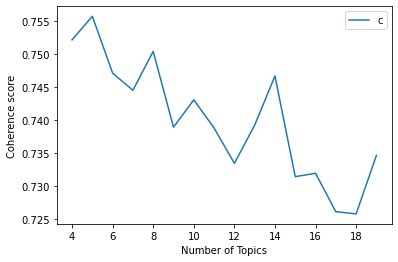

In [ ]:
##Defining our boundaries, the maximumm number of topic we want is 20, which is already a lot. 
start = 4
limit = 20 
step = 1

model_list, coherence_values = coherence_score(
    dictionary, corpus = tfidf_corpus, texts = textList, start = start, limit = limit, step = step)

#show graphs

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print(" for n_topics =", m, ", Coherence Value =", round(cv, 6))

 for n_topics = 4 , Coherence Value = 0.752128
 for n_topics = 5 , Coherence Value = 0.755694
 for n_topics = 6 , Coherence Value = 0.747103
 for n_topics = 7 , Coherence Value = 0.744518
 for n_topics = 8 , Coherence Value = 0.750389
 for n_topics = 9 , Coherence Value = 0.738939
 for n_topics = 10 , Coherence Value = 0.743066
 for n_topics = 11 , Coherence Value = 0.738816
 for n_topics = 12 , Coherence Value = 0.733476
 for n_topics = 13 , Coherence Value = 0.739237
 for n_topics = 14 , Coherence Value = 0.746674
 for n_topics = 15 , Coherence Value = 0.731466
 for n_topics = 16 , Coherence Value = 0.731974
 for n_topics = 17 , Coherence Value = 0.726178
 for n_topics = 18 , Coherence Value = 0.725838
 for n_topics = 19 , Coherence Value = 0.734662


####Turns out it is n = 5, which has coherence value of 0.75. We're going to use this to create our real LdaModel this time

In [ ]:
model = LdaModel(corpus = tfidf_corpus,
                 id2word = dictionary,
                 num_topics = 5,
                 alpha = "auto",
                 random_state = 100)

for i, topic in model.print_topics(-1):
    print('Topic: {} Word: {}'.format(i, topic))

Topic: 0 Word: 0.021*"record" + 0.020*"death" + 0.016*"says" + 0.015*"qld" + 0.014*"cup" + 0.013*"probe" + 0.012*"wa" + 0.012*"race" + 0.012*"public" + 0.012*"river"
Topic: 1 Word: 0.036*"man" + 0.021*"council" + 0.015*"nsw" + 0.015*"court" + 0.015*"raid" + 0.015*"go" + 0.014*"arsenal" + 0.014*"plane" + 0.013*"leaves" + 0.013*"rotterdam"
Topic: 2 Word: 0.020*"us" + 0.019*"man" + 0.019*"bid" + 0.018*"work" + 0.015*"world" + 0.014*"charged" + 0.013*"plan" + 0.013*"drought" + 0.013*"back" + 0.012*"stay"
Topic: 3 Word: 0.030*"fire" + 0.021*"trial" + 0.019*"water" + 0.016*"warne" + 0.016*"war" + 0.014*"us" + 0.014*"community" + 0.013*"club" + 0.012*"sa" + 0.012*"back"
Topic: 4 Word: 0.027*"police" + 0.026*"new" + 0.023*"rain" + 0.017*"win" + 0.013*"may" + 0.013*"takes" + 0.012*"council" + 0.012*"boost" + 0.012*"us" + 0.012*"denies"


##That is the topic-word distributions for all our topics. We're pretty much done here, but we need some visualization!

In [ ]:
topwords = []

for t in range(model.num_topics):
    topwords.extend([(t, ) + x for x in model.show_topic(t, topn = 10)])

df = pd.DataFrame(topwords, columns=['Topic', 'Word', 'Probability'])
print(df)

    Topic       Word  Probability
0       0     record     0.020653
1       0      death     0.020424
2       0       says     0.015945
3       0        qld     0.015488
4       0        cup     0.013855
5       0      probe     0.012718
6       0         wa     0.012405
7       0       race     0.012257
8       0     public     0.012061
9       0      river     0.011619
10      1        man     0.036335
11      1    council     0.021235
12      1        nsw     0.015449
13      1      court     0.015331
14      1       raid     0.015208
15      1         go     0.014860
16      1    arsenal     0.014287
17      1      plane     0.013731
18      1     leaves     0.013314
19      1  rotterdam     0.013281
20      2         us     0.020026
21      2        man     0.019235
22      2        bid     0.018537
23      2       work     0.017724
24      2      world     0.015383
25      2    charged     0.013541
26      2       plan     0.012959
27      2    drought     0.012609
28      2     

###We're using a library called pyLDAvis, which can be used to visualize our LDA model

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
data = gensimvis.prepare(model, tfidf_corpus, dictionary, mds = "mmds")
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.048625  0.122786       1        1  21.282194
3     -0.038781 -0.131506       2        1  21.243028
0     -0.129175 -0.002359       3        1  20.715112
2      0.106071 -0.067347       4        1  18.804670
1      0.110510  0.078426       5        1  17.954996, topic_info=      Term       Freq      Total Category  logprob  loglift
115    man  17.000000  17.000000  Default  30.0000  30.0000
174  trial   6.000000   6.000000  Default  29.0000  29.0000
2     fire  11.000000  11.000000  Default  28.0000  28.0000
208    bid   5.000000   5.000000  Default  27.0000  27.0000
147    new  10.000000  10.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
22     opp   1.770070   4.156741   Topic5  -4.8737   0.8636
159   face   2.229417   6.977460   Topic5  -4.6430   0.5764
199     us   2.809265  16.092151   Topic5  -4.4118  -0.0281
74    govt   2.115342   9.501041   Topic5  -4.6955   0.2151
163    may   1.915946   6.695022   Topic5  -4.7945   0.4661

[235 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
24        2  0.310088        10
24        4  0.310088        10
24        5  0.620175        10
89        2  0.300745   accused
89        4  0.300745   accused
...     ...       ...       ...
157       4  0.616084     world
157       5  0.154021     world
148       1  0.638597  zimbabwe
148       3  0.212866  zimbabwe
148       5  0.212866  zimbabwe

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

###We have created our visualization! We can save it in HTML format for later uses.

In [ ]:
pyLDAvis.save_html(data, 'lda-visualization.html')